In [2]:
import itertools
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt

In [10]:
"""Overall initialization"""

# Overall initialization
seed = 41
torch.manual_seed(seed)

# Data types
dtype = torch.FloatTensor
np_dtype = np.float32

# PI and Gaussian PDF constants in Torch
pi_tensor = torch.Tensor([np.pi])
pi_variable = Variable(pi_tensor)
normal_log_likelihood_const = -torch.log(torch.sqrt(2 * pi_variable))

# Use cross entropy or L2-norm for reconstruction loss?
use_cross_entropy = True

# Model parameters
latent_size = 20

# Training parameters
batch_size = 128
learning_rate = 1e-3

# Data parameters
mnist_dataset_path = 'mnist_dataset'

# Hidden layer units in encoder and decoder (each entry is one layer)
enc_hidden_units_list = [512, 512]
dec_hidden_units_list = [512, 512]

In [4]:
"""Datasets"""

# Only return full batches
kwargs = {}
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(mnist_dataset_path, train=True, download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(mnist_dataset_path, train=False,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

# Retrieve size of images
image, label = train_loader.dataset[0]
image_size_x, image_size_y = image.size()[-2:]
image_size_flat = image_size_x * image_size_y

In [6]:
"""Network model for encoder and decoder"""

class VAE(nn.Module):

    def __init__(self, input_size, latent_size, enc_hidden_units_list, dec_hidden_units_list):
        super(VAE, self).__init__()

        self.input_size = input_size
        self.latent_size = latent_size

        # Encoder layers
        self.enc_fc_list = nn.ModuleList()
        prev_layer_size = input_size
        for i, num_hidden_units in enumerate(enc_hidden_units_list):
            fc = nn.Linear(prev_layer_size, num_hidden_units)
            self.enc_fc_list.append(fc)
            prev_layer_size = num_hidden_units
        self.enc_mu = nn.Linear(prev_layer_size, latent_size)
        self.enc_logvar = nn.Linear(prev_layer_size, latent_size)

        # Decoder layers
        self.dec_fc_list = nn.ModuleList()
        prev_layer_size = latent_size
        for i, num_hidden_units in enumerate(dec_hidden_units_list):
            fc = nn.Linear(prev_layer_size, num_hidden_units)
            self.dec_fc_list.append(fc)
            prev_layer_size = num_hidden_units
        self.dec_reconstruct = nn.Linear(prev_layer_size, input_size)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h = x
        for fc in self.enc_fc_list:
            h = fc(h)
            h = self.relu(h)
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar

    def decode(self, z):
        h = z
        for fc in self.dec_fc_list:
            h = fc(h)
            h = self.relu(h)
        x_reconstruct = self.dec_reconstruct(h)
        x_reconstruct = self.sigmoid(x_reconstruct)
        return x_reconstruct

    def sample_latent_space(self, num_samples, dtype=torch.FloatTensor, volatile=False):
        z = Variable(torch.randn(num_samples, self.latent_size).type(dtype), volatile=volatile)
        return z

    def sample_latent_space_parametrized(self, mu, logvar):
        if self.training:
          sigma = logvar.mul(0.5).exp_()
          eps = Variable(sigma.data.new(sigma.size()).normal_())
          return eps.mul(sigma).add(mu)
        else:
          return mu

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.sample_latent_space_parametrized(mu, logvar)
        x_reconstruct = self.decode(z)
        return x_reconstruct, mu, logvar

model = VAE(image_size_flat, latent_size, enc_hidden_units_list, dec_hidden_units_list)

In [7]:
"""KL divergence between gaussian with diagonal covariance and zero-mean, unit-variance gaussian"""

def kl_divergence_normal_uncorrelated_identity_logvar(mu1, logvar1):
    kld = 0.5 * torch.sum(mu1.pow(2) + logvar1.exp() - 1 - logvar1, dim=-1)
    return kld

In [33]:
"""Training"""

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def loss_function(true_x, x, mu, logvar, return_loss_components=False):
    # Compute KL-divergence between `N(latent_mu, latent_sigma)` and unit normal distribution
    kld_q = kl_divergence_normal_uncorrelated_identity_logvar(mu, logvar)
    kld_q = torch.mean(kld_q) / (image_size_flat)
    # Compute data loss
    if use_cross_entropy:
        bce = nn.functional.binary_cross_entropy(x, true_x.view(-1, image_size_flat))
        recon_loss = bce
    else:
        recon_loss = torch.mean((true_x.view(-1) - x.view(-1)).pow(2))
    # Total loss
    loss = recon_loss + kld_q
    if return_loss_components:
        return loss, recon_loss, kld_q
    else:
        return loss

model.training = True

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0
    train_recon_loss = 0
    train_kld = 0
    for i, (images, _) in enumerate(train_loader):
        x = Variable(images)

        optimizer.zero_grad()
        reconstruct_x, mu, logvar = model(x)
        loss, recon_loss, kld = loss_function(x, reconstruct_x, mu, logvar, return_loss_components=True)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        train_recon_loss += recon_loss.data[0]
        train_kld += kld.data[0]
        if i % 100 == 0:
            print("epoch={}, i={}".format(epoch, i))
            print("  loss: {:.4f}, recon_loss: {:.4f}, kld: {:.4f}".format(
                train_loss / (i + 1), train_recon_loss / (i + 1), train_kld / (i + 1)))
    train_loss *= batch_size / len(train_loader.dataset)
    train_recon_loss *= batch_size / len(train_loader.dataset)
    train_kld *= batch_size / len(train_loader.dataset)
    print('====> Train set loss: {:.4f}, recon_loss: {:.4f}, kld: {:.4f}'.format(
        train_loss, train_recon_loss, train_kld))

epoch=0, i=0
  loss: 0.1287, recon_loss: 0.1041, kld: 0.0246
epoch=0, i=100
  loss: 0.1274, recon_loss: 0.1026, kld: 0.0248
epoch=0, i=200
  loss: 0.1271, recon_loss: 0.1023, kld: 0.0248
epoch=0, i=300
  loss: 0.1270, recon_loss: 0.1023, kld: 0.0248
epoch=0, i=400
  loss: 0.1272, recon_loss: 0.1024, kld: 0.0248
====> Train set loss: 0.1273, recon_loss: 0.1025, kld: 0.0248
epoch=1, i=0
  loss: 0.1285, recon_loss: 0.1036, kld: 0.0249
epoch=1, i=100
  loss: 0.1268, recon_loss: 0.1020, kld: 0.0249
epoch=1, i=200
  loss: 0.1267, recon_loss: 0.1018, kld: 0.0249
epoch=1, i=300
  loss: 0.1270, recon_loss: 0.1022, kld: 0.0249
epoch=1, i=400
  loss: 0.1269, recon_loss: 0.1021, kld: 0.0249
====> Train set loss: 0.1269, recon_loss: 0.1021, kld: 0.0249
epoch=2, i=0
  loss: 0.1277, recon_loss: 0.1030, kld: 0.0247
epoch=2, i=100
  loss: 0.1262, recon_loss: 0.1013, kld: 0.0249
epoch=2, i=200
  loss: 0.1264, recon_loss: 0.1015, kld: 0.0249
epoch=2, i=300
  loss: 0.1265, recon_loss: 0.1016, kld: 0.0249


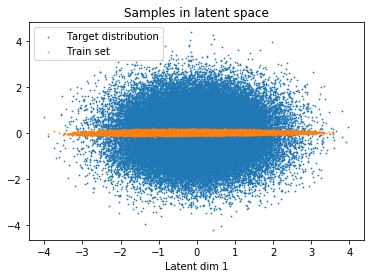

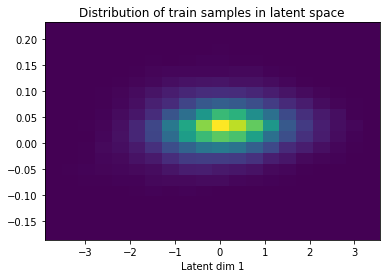

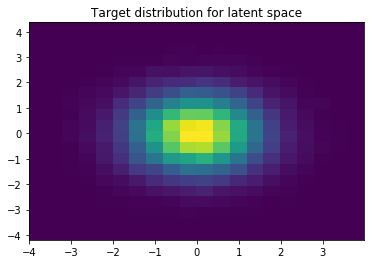

In [32]:
"""Plot samples in latent space"""

model.eval()
latent_samples_mu = []
latent_samples_logvar = []
for i, (images, _) in enumerate(train_loader):
    x = Variable(images, volatile=True)
    recon_x, mu, logvar = model(x)
    latent_samples_mu.append(mu.data.numpy())
    latent_samples_logvar.append(logvar.data.numpy())
latent_samples_mu = np.concatenate(latent_samples_mu, axis=0)
latent_samples_logvar = np.concatenate(latent_samples_logvar, axis=0)

latent_dim1 = 0
latent_dim2 = 1
x = latent_samples_mu[..., latent_dim1].ravel()
y = latent_samples_mu[..., latent_dim2].ravel()
# Generate samples from target latent distribution, i.e. N(0, I)
target_x, target_y = np.random.randn(len(x)), np.random.randn(len(x))

plt.scatter(target_x, target_y, s=0.5)
plt.scatter(x, y, s=0.5)
plt.title("Samples in latent space")
plt.xlabel("Latent dim {:d}".format(latent_dim1))
plt.xlabel("Latent dim {:d}".format(latent_dim2))
plt.legend(["Target distribution", "Train set"])
plt.show()
plt.close()

plt.figure()
plt.hist2d(x, y, 20)
plt.title("Distribution of train samples in latent space")
plt.xlabel("Latent dim {:d}".format(latent_dim1))
plt.xlabel("Latent dim {:d}".format(latent_dim2))
plt.show()
plt.close()

plt.figure()
plt.hist2d(target_x, target_y, 20)
plt.title("Target distribution for latent space")
plt.show()
plt.close()

In [ ]:
"""Compare input and reconstructed images"""
model.eval()
test_loss = 0
for i, (images, _) in enumerate(test_loader):
    x = Variable(images, volatile=True)
    recon_x, mu, logvar = model(x)
    test_loss += loss_function(x, recon_x, mu, logvar).data[0]
    if i == 0:
        n = min(x.size(0), 8)
        comparison = torch.cat([x[:n],
                                recon_x.view(batch_size, 1, image_size_x, image_size_y)[:n]])
        for j in range(n):
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(comparison[j, 0, ...].data.numpy(), cmap="gray")
            plt.subplot(1, 2, 2)
            plt.imshow(comparison[n + j, 0, ...].data.numpy(), cmap="gray")
            plt.show()

test_loss *= batch_size / len(test_loader.dataset)
print('====> Test set loss: {:.4f}'.format(test_loss))

(28, 28)


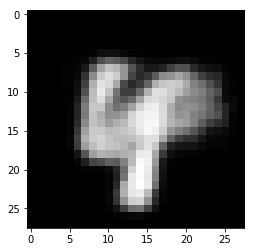

(28, 28)


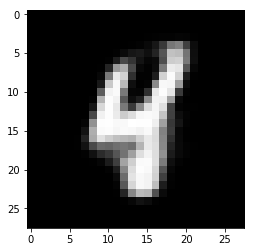

(28, 28)


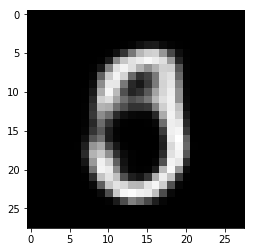

(28, 28)


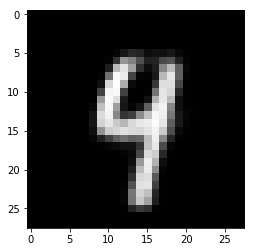

(28, 28)


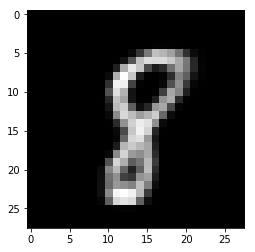

(28, 28)


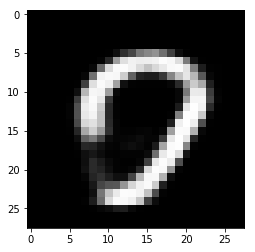

(28, 28)


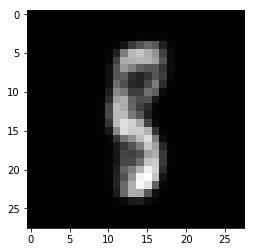

(28, 28)


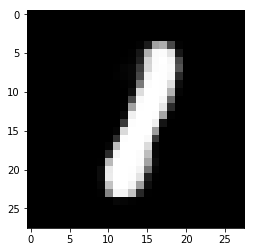

In [27]:
"""Sample some images"""
model.eval()
num_samples_to_generate = 8
samples = Variable(torch.randn(num_samples_to_generate, latent_size))
samples = model.decode(samples)
for i in range(num_samples_to_generate):
    sample = samples[i, ...]
    sample = sample.view(image_size_y, image_size_x)
    sample = sample.data.numpy()
    print(sample.shape)
    plt.figure()
    plt.imshow(sample, cmap="gray")
    plt.show()

50333 26140


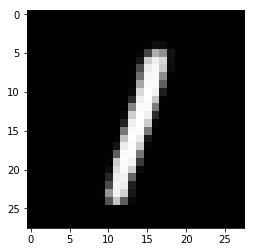

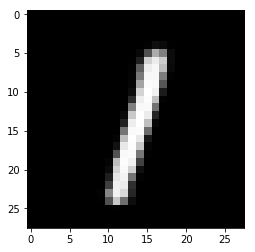

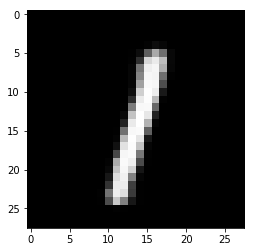

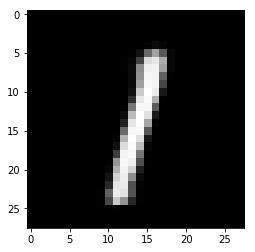

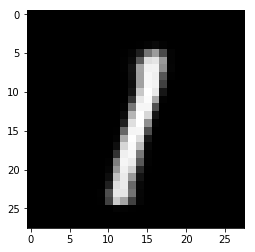

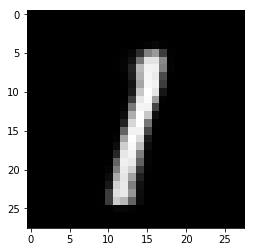

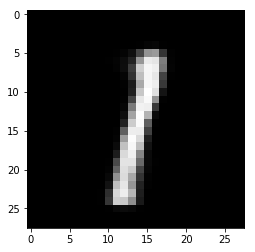

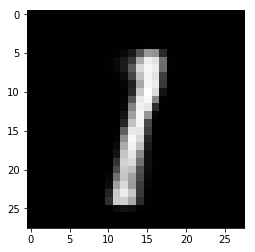

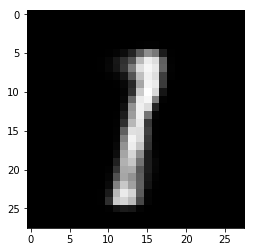

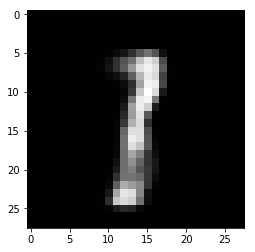

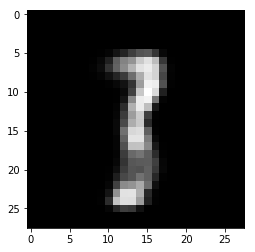

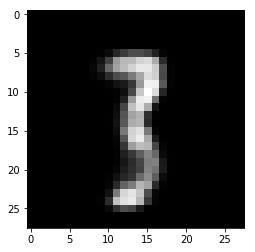

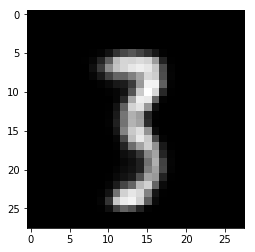

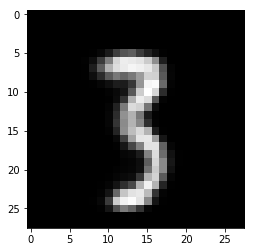

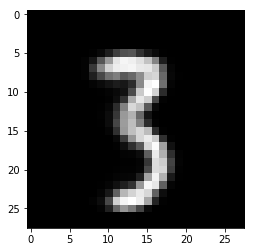

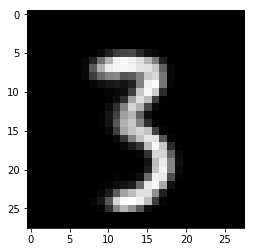

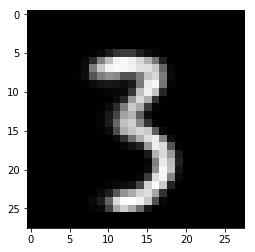

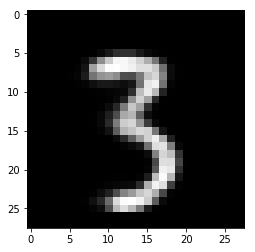

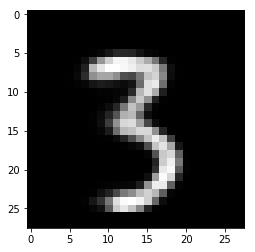

In [28]:
"""Interpolate between images"""
idx1, idx2 = np.random.choice(np.arange(len(train_loader.dataset)), size=2, replace=False)
print(idx1, idx2)
x1, mu1, sigma1 = model(Variable(torch.Tensor(train_loader.dataset[idx1][0]).type(dtype), volatile=True))
x2, mu2, sigma2 = model(Variable(torch.Tensor(train_loader.dataset[idx2][0]).type(dtype), volatile=True))
w = Variable(torch.linspace(0, 1, 20))
z = mu1 + (mu2 - mu1) * w[:, None]
# print(z.data.shape)
x = model.decode(z)
x1 = x1.data.numpy().reshape((image_size_y, image_size_x))
x2 = x2.data.numpy().reshape((image_size_y, image_size_x))
x = x.data.numpy().reshape((-1, image_size_y, image_size_x))

plt.figure()
plt.imshow(x1, cmap="gray")
plt.close()
for i in range(x.shape[0]):
    plt.figure()
    plt.imshow(x[i, ...], cmap="gray")
plt.close()
plt.figure()
plt.imshow(x2, cmap="gray")
plt.close()
plt.show()
